# TODO: Go deeeper
## Key Points
1. **Initialization matters**: wants to logits to be close to 0 at the very beginning to avoid large losses (avoid confidently wrong of softmax)
2. **Saturation of the tanh function**: break the gradient flow. plot tanh intermediate values to see how it saturates.
   1. Gradient always deceases as we go back through tanh.
   2. Dead neurons: tanh (or sigmoid or relu) satrurates and cause the gradient to be 0 for all instances.
   3. Initialization: motivation is to keep the distribution's variance of the input and output of each layer the same (and reasonable large). If no activation, can multiply by sqrt of (1 / num_of_inputs).
   4. Kaiming's initialization: for relu, multiply by sqrt of (2 / number of inputs), where 2 is called "gain", used to compensate for the fact that relu is not symmetric around 0. "gain" has different values for different activation functions (see pytorch docs aboud weight initialization).
   5. "Gain" is important: if no activation, then using gain=1 is enough to keep the variance the same, but with squashing activation functions like tanh, the variance will be smaller and smaller, so we need to multiply by a larger value to keep the variance the same.
   6. Modern techniques like Adam, BN, residual connections, make initialization less important, but still useful.
3. **BN motivation**: make the outputs before the activation function subject to a Gaussian (if too small, tanh has no effect; if too large, tanh saturates)
   1. It's a direct idea: just normalize it to have mean 0 and variance 1.
   2. Then scale and shift using learnable parameters.
   3. BN's side effect: the activation value of an instance is dependent on the other instances in the batch (which is randmomly sampled), thus cause jittering in the training process. But this turns out to be a good thing, as it acts as a regularizer/data augmentation.
   4. BN in inference: use the mean and variance of the entire training set or maintain a running mean and variance during training.
   5. Bias is no more needed in the linear layer, as BN has its own bias (mathematically, the bias term will be substrated out by the mean of BN, so it never learns).
   6. Momentum in BN: in running mean and variance, use momentum to update the mean and variance. (small batch size can cause large variance in estimation, so use a smaller momentum value to smooth it out)
## Implementation detail
1. Torchify the code of Linear, BatchNorm1d and Tanh, which should have `__call__()` and `parameters()` methods.
2. Write: build MLP, enable the grad tracking, initialize the weights, training process.
3. No BN, run for only 1 epoch, visualize (can try some other "gain" values to see the effect):
   1. Tanh Value distribution of activation. (use Tanh because its value is between -1 and 1, so can see the distribution better)
   2. Tanh Grad distribution of activation.
   3. Linear layer weight distribution.
   4. Update:data ratio over time (to see the speed of training of each layer) (use the ratio of the .std() to calculate)
4. Add BN and check the robustness (to "gain" values)
5. Other details:
   1. The position of the BN.
   2. Make the last layer less confident (avoid large loss at the beginning).

In [ ]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
import random

# Data preparation

In [ ]:
words = open("../names.txt", "r").read().splitlines()
chars = sorted(set('.'.join(words)))
stoi = {char:i for i, char in enumerate(chars)}
itos = {i:char for i, char in enumerate(chars)}

In [ ]:
ratio1 = 0.8
ratio2 = 0.9
chunk = 3

def create_data(ws, chunk=3):
    X = []
    Y = []
    
    for word in ws:
        Xt = [0] * chunk # Cool
        for ch in word + '.': # Dont forget to add ending token.
            X.append(Xt)
            Y.append(stoi[ch])   
            Xt = Xt[1:] + [stoi[ch]]

    return torch.tensor(X), torch.tensor(Y)

random.shuffle(words) # No obvious affect (original words already shuffled)
n1 = int(ratio1 * len(words))
n2 = int(ratio2 * len(words))
Xt, Yt = create_data(words[:n1], chunk=chunk)
Xdev, Ydev = create_data(words[n1:n2], chunk=chunk)
Xte, Yte = create_data(words[n2:], chunk=chunk)
print(Xt.shape)
print(Xdev.shape)

# Construct the component classes

In [ ]:
class Linear:
    def __init__(self, n_in, n_out, bias=True):
        self.n_in = n_in
        self.n_out = n_out
        self.W = torch.randn((n_in, n_out)) * (n_in)**(-0.5)
        self.b = torch.zeros(n_out) if bias else None # zeros
        self.out = None # For visualization

    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out   

    def parameters(self):
        return [self.W, self.b] if self.b is not None else [self.W]
    
    def __repr__(self):
        return f"Linear({self.n_in}, {self.n_out})"

test_linear = Linear(10, 50)
x_test = torch.randn((32, 10))
print(test_linear(x_test).shape)
print(test_linear.parameters()[0].shape)

In [ ]:
class BN1d:
    def __init__(self, num_feat, eps=1e-5, momentum=0.1):
        self.n_feat = num_feat
        self.eps = eps
        self.momentum = momentum

        self.gamma = torch.ones(num_feat) # ones
        self.beta = torch.zeros(num_feat) # zeros

        self.training = True
        self.rmean = torch.ones(num_feat) 
        self.rvar = torch.zeros(num_feat)

        self.out = None

    def __call__(self, x):
        if self.training:
            meani = torch.mean(x, dim=0, keepdim=True) 
            vari = torch.var(x, dim=0, keepdim=True)
        else:
            meani = self.rmean
            vari = self.rvar
        
        if not self.training:
            self.rmean = (1- self.momentum) * self.rmean + self.momentum * meani 
            self.rvar = (1 - self.momentum) * self.rvar + self.momentum * vari
        
        self.out = self.gamma * (x - meani) / torch.sqrt(vari + self.eps) + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
    def __repr__(self):
        return f"BN1d({self.n_feat})"

BN_test = BN1d(4)
x_test = torch.randn((5, 4))
print(BN_test(x_test))
print((x_test - x_test.mean(0, keepdim=True))/(torch.sqrt(x_test.var(0, keepdim=True) + 1e-5)))

In [ ]:
class Tanh:
    def __init__(self):
        self.out = None

    def __call__(self, x):
        self.out = torch.tanh(x)       
        return self.out

    def parameters(self):
        return None
    
    def __repr__(self):
        return "Tanh()"

# Build the MLP

In [ ]:
X_ = F.one_hot(Xt, num_classes=27).float()
print(X_.shape)
W = torch.randn(27, 3)
print((X_ @ W).shape)

In [ ]:
def get_embedding(embedding_size):
    return torch.randn(27, embedding_size, requires_grad=True)

test_embed = get_embedding(10)
print(test_embed.shape)

In [ ]:
def get_MLP(chunk, embedding_size, num_neurons, BN=True, eps=1e-5, momentum=0.1):
    layers = []
    n_in = chunk * embedding_size
    for num in num_neurons:
        layer = [Linear(n_in, num, False), BN1d(num, eps, momentum), Tanh()] if BN else [Linear(n_in, num, True), Tanh()]
        layers.extend(layer)
        n_in = num
    
    layer = [Linear(num_neurons[-1], 27, False), BN1d(27, eps, momentum)] if BN else [Linear(num_neurons[-1], 27, True)]
    layers.extend(layer)
    return layers

layers = get_MLP(3, 10, [300])
print(layers)

In [ ]:
def weight_init(layers, gain=5/3):
    if isinstance(layers[-1], BN1d): # Less confident
        layers[-2].W *= 0.1
    else:
        layers[-1].W *= 0.1
    for layer in layers:
        if isinstance(layer, Linear):
            layer.W *= gain

# Train & val scripts

In [ ]:
def go_through(xx, embed, layers):
    # Through embedding
    xx = F.one_hot(xx, num_classes=27).float()
    xx = (xx @ embed).view(xx.shape[0], -1)
    # xx = F.tanh(xx) # Do we really need this?

    # Through MLP
    for layer in layers:
        xx = layer(xx)
    return xx

xx_test = Xt[:4].clone()
xx_test = go_through(xx_test, test_embed, layers)
print(xx_test.shape)

In [ ]:
def get_params(layers):
    param_list = []
    for layer in layers:
        params = layer.parameters()
        if params is not None:
            param_list.extend(params)
    return param_list

In [ ]:
def train_MLP(X, Y, embed, layers, batch_size, epochs, lr):
    param_list = [embed]
    param_list.extend(get_params(layers))
    for param in param_list:
        param.requires_grad = True

    loss_list = []
    update_ratio = []
    for epoch in range(epochs):
        # Zero out the grad
        for param in param_list:
            param.grad = None

        # Select batch
        idx = torch.randint(0, len(X), (batch_size, ))
        xx = X[idx]
        yy = Y[idx]

        # Forward pass
        xx = go_through(xx, embed, layers)

        # Retain grads for visualization
        for layer in layers:
            layer.out.retain_grad()

        # Compute loss
        loss = F.cross_entropy(xx, yy)

        # Backward
        loss.backward()
        loss_list.append(loss.item())

        # Record ratio to visualize
        with torch.no_grad(): # no_grad()
            update_ratio.append([((lr * param.grad).std() / param.data.std()).log10().item() for param in param_list]) # log10.item()

        # Update params (Use tensor.data, because leaf tensor cannot do in-place operations)
        for param in param_list:
            param.data += -lr * param.grad
        
    return loss_list, update_ratio 

# chunk = 3
# embedding_size = 10
# embed = get_embedding(embedding_size)
# layers = get_MLP(chunk, embedding_size, [100, 100, 100, 100, 100], BN=False)
# param_list = [embed]
# param_list.extend(get_params(layers))
# weight_init(layers, gain=5/3)
# loss_list, update_ratio = train_MLP(Xt, Yt, embed, layers, 64, 5000, 0.1)
# plt.plot(loss_list)

# Visualize intermediate values

In [ ]:
def visualize_activation_value(layers):
    plt.figure(figsize=(20, 5))
    legends = []
    for i, layer in enumerate(layers):
        if isinstance(layer, Tanh):
            xx = layer.out
            print("Layer%d %s -- mean: %.2f | std: %.2f | saturation: %.2f%%" %
                  (i, layer, xx.mean(), xx.std(), (xx.abs() > 0.97).float().mean()))
            hy, hx = torch.histogram(xx, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f"Layer{i} {layer}")
    plt.legend(legends)
    plt.title("activation value distribution")
    
visualize_activation_value(layers)

## activation values
- No BN, gain=5/3: Saturated at the first layer, but getting better latter. And the std tends not to be converge to 0 but roughly 0.5 - 0.6, which is good.
![activation value distribution](../images/No_BN_5_3_Gain.png)
- No BN, gain=1, less saturated, but std tends to be smaller and smaller, which is not good. Pure Linear preserve the variance, but tanh, as a squashing function, will break this unless we use a larger gain.
![activation value distribution](../images/No_BN_1_Gain.png)
- No BN, gain>=3, this case the saturation is quite severe.
- Add BN, the result will be a lot better and robust to the gain value.

In [ ]:
def visualize_activation_grad(layers):
    plt.figure(figsize=(20, 5))
    legends = []
    for i, layer in enumerate(layers):
        if isinstance(layer, Tanh):
            xx = layer.out.grad
            print("Layer %d %s -- mean: %+f | std: %e" % (i, layer, xx.mean(), xx.std()))
            hy, hx = torch.histogram(xx, density=True)
            plt.plot(hx[:-1], hy)
            legends.append(f"Layer{i} {layer}")
    plt.legend(legends)
    plt.title("activation grad distribution")

visualize_activation_grad(layers)

## activation gradients
- No BN, gain=5/3: The gradient stays almost the same, neither shrinks nor explodes, which is good.
![activation gradient distribution](../images/Grad_No_BN_5_3_Gain.png)
- No BN, gain=0.5: The gradient's variance is getting larger.
![activation gradient distribution](../images/Grad_No_BN_0.5_Gain.png)
- No BN, larger gain, the gradient will tend to explode.
- Again, add BN, the result will be a lot better and robust to the gain value.

In [ ]:
def visualize_weights(param_list):
    plt.figure(figsize=(20, 5))
    legends = []
    for param in param_list:
        if param.ndim > 1:
            w = param
            ww = w.grad
            print("weight(%d, %d) -- mean: %+f | std: %e | grad:data scale ratio: %e" % (w.shape[0], w.shape[1], ww.mean(), ww.std(), ww.std() / w.std()))
            hy, hx = torch.histogram(ww, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f"weight({w.shape[0]}, {w.shape[1]})")
    plt.legend(legends)
    plt.title("weights grad distribution")

visualize_weights(param_list)

## Linear layer weights
- No BN, gain=5/3. The grad:data scale ratio of the last layer is several times larger than other layers, which indicates that the last layer may be updated faster. Use modern optimizer may ease this.

weight(27, 10) -- mean: +0.002877 | std: 1.685361e-02 | grad:data scale ratio: 1.746943e-02

weight(30, 100) -- mean: +0.000466 | std: 1.569925e-02 | grad:data scale ratio: 5.231872e-02

weight(100, 100) -- mean: +0.000128 | std: 1.358390e-02 | grad:data scale ratio: 8.207078e-02

weight(100, 100) -- mean: -0.000185 | std: 1.249495e-02 | grad:data scale ratio: 7.499947e-02

weight(100, 100) -- mean: +0.000056 | std: 1.192545e-02 | grad:data scale ratio: 7.160348e-02

weight(100, 100) -- mean: +0.000086 | std: 1.038254e-02 | grad:data scale ratio: 6.230477e-02

weight(100, 27) -- mean: +0.000000 | std: 1.833592e-02 | grad:data scale ratio: 1.115449e-01
![weights](../images/Weight_No_BN_5_3_Gain.png)
- BN, gain=5/3, the grad:data scale ratio is a lot better.

weight(27, 10) -- mean: +0.000000 | std: 1.801080e-02 | grad:data scale ratio: 1.807870e-02

weight(30, 100) -- mean: -0.000062 | std: 1.456459e-02 | grad:data scale ratio: 4.795692e-02

weight(100, 100) -- mean: +0.000048 | std: 1.363576e-02 | grad:data scale ratio: 8.307827e-02

weight(100, 100) -- mean: -0.000063 | std: 1.125054e-02 | grad:data scale ratio: 6.777788e-02

weight(100, 100) -- mean: +0.000010 | std: 9.727866e-03 | grad:data scale ratio: 5.810474e-02

weight(100, 100) -- mean: -0.000090 | std: 8.363669e-03 | grad:data scale ratio: 5.019680e-02

weight(100, 27) -- mean: +0.000012 | std: 1.448200e-02 | grad:data scale ratio: 8.823942e-02
![weights](../images/Weight_BN_5_3_Gain.png)

In [ ]:
def visualize_ratio(ratio):
    plt.figure(figsize=(20, 5))
    legends = []
    for i, param in enumerate(param_list):
        if param.ndim > 1:
            plt.plot([ratio[j][i] for j in range(len(ratio))])
            legends.append("weight(%d, %d), index %d" % (param.shape[0], param.shape[1], i))
    plt.legend(legends)
    plt.title("Ratio")

visualize_ratio(update_ratio)
plt.plot([0, len(update_ratio)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot

## Linear layer update:data ratio
- No BN, gain=5/3: The last layer is obviously an outlier, because it has multiplied by 0.1 to make the output less confident.
![update:data ratio](../images/ratio_No_BN_5_3_Gain.png)
- No BN, gain=5/3, but without the last layer's multiplication, the update:data ratio is more balanced.
![update:data ratio](../images/ratio_No_BN_5_3_Gain_confident.png)

# Train & Eval the MLP

In [142]:
chunk = 3
embedding_size = 10
embed = get_embedding(embedding_size)
layers = get_MLP(chunk, embedding_size, [100, 100, 100, 100, 100], BN=True)
param_list = [embed]
param_list.extend(get_params(layers))
weight_init(layers, gain=5/3)

batch_size = 64
epochs = 40000
lr = 0.1

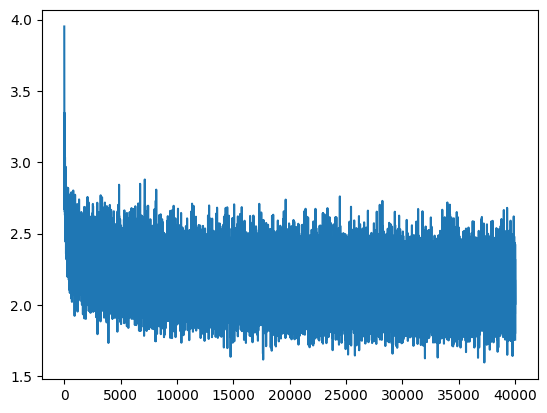

In [143]:
loss_list, update_ratio = train_MLP(Xt, Yt, embed, layers, batch_size, epochs, lr)
plt.plot(loss_list)

In [159]:
for layer in layers:
    if isinstance(layer, BN1d):
        layer.training = False

In [160]:
def dev_MLP(X, Y, embed, layers):
    with torch.no_grad():
        xx = go_through(X, embed, layers)
        loss = F.cross_entropy(xx, Y)
        print(loss.item())

In [161]:
dev_MLP(Xdev, Ydev, embed, layers)

2475.998779296875


# Infer

In [ ]:
def infer_names(num, embed, layers): # Cant infer in parallel
    for i in range(num):
        result = []
        xx = [0] * chunk
        while True:
            logits = go_through(torch.tensor(xx).unsqueeze(0), embed, layers)
            probs = logits.exp() / logits.exp().sum(dim=1)
            next_token = torch.multinomial(probs[0], num_samples=1)
            result.append(next_token.item())
            xx = xx[1:] + [next_token]
            if next_token == 0:
                break
        result = [itos[char] for char in result]
        print(''.join(result))
    
infer_names(2, embed, layers)

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan]], grad_fn=<AddBackward0>)


C:\Users\90534\AppData\Local\Temp\ipykernel_48260\4283806034.py:19: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1831.)
  vari = torch.var(x, dim=0, keepdim=True)


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0